In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import h5py
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, MaxPooling2D, Dense, Conv2D, Conv2DTranspose, Reshape, UpSampling2D, Layer, InputSpec, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers, activations, initializers, constraints, Sequential
from tensorflow.keras.constraints import UnitNorm, Constraint

In [3]:
import sklearn
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import decomposition
import scipy

#### Load data

Load data from ptychography simulation datasets from Panpan.

Also 2 other versions:
    crop the images to the central 32x32,
    crop the images to the central 64x64 and merged the adjacent cells resulting in 32x32

In [4]:
#change path to your location
pathToSimData="/home/drewp/Research/InPixelAI/simulated_data"

with h5py.File(f"{pathToSimData}/data_cell_phase_n2e7.h5", "r") as f:
    dataFull = f['exchange/data'][...]
with h5py.File(f"{pathToSimData}/data_cell_phase_n2e7_ref.h5", "r") as f:
    dataFull_ref = f['exchange/data'][...]

print(dataFull.shape)
print(dataFull_ref.shape)

(1, 4488, 72, 72)
(1, 4488, 72, 72)


In [5]:
# on current version of reconstruction, the square root of intensity should be used  

# dataCropped = dataFull[:,:,36-16:36+16,36-16:36+16].real**2
# dataCropped_ref = dataFull_ref[:,:,36-16:36+16,36-16:36+16].real**2
dataCropped = dataFull[:,:,36-16:36+16,36-16:36+16].real
dataCropped_ref = dataFull_ref[:,:,36-16:36+16,36-16:36+16].real
with h5py.File(f'{pathToSimData}/data_cell_phase_n2e7_32x32.h5','w') as h5f:
    h5f.create_dataset('exchange/data',data=dataCropped)
  
#dataMerge = (dataFull[:,:,4:68:2,4:68:2].real + 
#             dataFull[:,:,4:68:2,5:69:2].real + 
#             dataFull[:,:,5:69:2,4:68:2].real + 
#             dataFull[:,:,5:69:2,5:69:2].real)**2
#dataMerge_ref = (dataFull_ref[:,:,4:68:2,4:68:2].real + 
#             dataFull_ref[:,:,4:68:2,5:69:2].real + 
#             dataFull_ref[:,:,5:69:2,4:68:2].real + 
#             dataFull_ref[:,:,5:69:2,5:69:2].real)**2
dataMerge = (dataFull[:,:,4:68:2,4:68:2].real + 
             dataFull[:,:,4:68:2,5:69:2].real + 
             dataFull[:,:,5:69:2,4:68:2].real + 
             dataFull[:,:,5:69:2,5:69:2].real)
dataMerge_ref = (dataFull_ref[:,:,4:68:2,4:68:2].real + 
             dataFull_ref[:,:,4:68:2,5:69:2].real + 
             dataFull_ref[:,:,5:69:2,4:68:2].real + 
             dataFull_ref[:,:,5:69:2,5:69:2].real)
with h5py.File(f'{pathToSimData}/data_cell_phase_n2e7_32x32merged.h5','w') as h5f:
    h5f.create_dataset('exchange/data',data=dataMerge)
    
print(dataCropped.shape)
print(dataMerge.shape)

(1, 4488, 32, 32)
(1, 4488, 32, 32)


Remove the first index of the data to prep for the autoencoder

In [6]:
# dataFull = dataFull.reshape(4488, 72, 72)
# dataFull_ref = dataFull_ref.reshape(4488, 72, 72)

dataCropped = dataCropped.reshape(4488, 32, 32)
dataCropped_ref = dataCropped_ref.reshape(4488, 32, 32)

dataMerge = dataMerge.reshape(4488, 32, 32)
dataMerge_ref = dataMerge_ref.reshape(4488, 32, 32)

Flatten the data, and also make a version of the data that is log scale

In [7]:
dataFullFlat = dataFull.reshape(-1,72*72)
dataFullFlatLog = np.where(dataFullFlat>0,np.log2(dataFullFlat*2),0)
dataFullRefFlat = dataFull_ref.reshape(-1,72*72)
dataFullRefFlatLog = np.where(dataFullRefFlat>0,np.log2(dataFullRefFlat*2),0)

dataCroppedFlat = dataCropped.reshape(-1,32*32)
dataCroppedFlatLog = np.where(dataCroppedFlat>0,np.log2(dataCroppedFlat*2),0)
dataCroppedRefFlat = dataCropped_ref.reshape(-1,32*32)
dataCroppedRefFlatLog = np.where(dataCroppedRefFlat>0,np.log2(dataCroppedRefFlat*2),0)

dataMergeFlat = dataMerge.reshape(-1,32*32)
dataMergeFlatLog = np.where(dataMergeFlat>0,np.log2(dataMergeFlat*2),0)
dataMergeRefFlat = dataMerge_ref.reshape(-1,32*32)
dataMergeRefFlatLog = np.where(dataMergeRefFlat>0,np.log2(dataMergeRefFlat*2),0)


<ipython-input-7-d4aa7614e6e6>:2: RuntimeWarning: divide by zero encountered in log2
  dataFullFlatLog = np.where(dataFullFlat>0,np.log2(dataFullFlat*2),0)
<ipython-input-7-d4aa7614e6e6>:4: RuntimeWarning: divide by zero encountered in log2
  dataFullRefFlatLog = np.where(dataFullRefFlat>0,np.log2(dataFullRefFlat*2),0)
<ipython-input-7-d4aa7614e6e6>:7: RuntimeWarning: divide by zero encountered in log2
  dataCroppedFlatLog = np.where(dataCroppedFlat>0,np.log2(dataCroppedFlat*2),0)
<ipython-input-7-d4aa7614e6e6>:9: RuntimeWarning: divide by zero encountered in log2
  dataCroppedRefFlatLog = np.where(dataCroppedRefFlat>0,np.log2(dataCroppedRefFlat*2),0)
<ipython-input-7-d4aa7614e6e6>:12: RuntimeWarning: divide by zero encountered in log2
  dataMergeFlatLog = np.where(dataMergeFlat>0,np.log2(dataMergeFlat*2),0)
<ipython-input-7-d4aa7614e6e6>:14: RuntimeWarning: divide by zero encountered in log2
  dataMergeRefFlatLog = np.where(dataMergeRefFlat>0,np.log2(dataMergeRefFlat*2),0)


Determine which indices of diffraction patterns to graph

In [8]:
N = [4218, 1911, 2059, 2099, 2457, 1864]

# Baseline model
1024 -> 128 -> 1024, Linear activation

### Cropped 32x32

In [9]:
inputs = Input(shape=(1024),name='input')
encoder = Dense(128, activation="linear")
decoder = Dense(1024, activation="linear")

x = encoder(inputs)
x = decoder(x)

autoencoder = Model(inputs, x)
autoencoder.summary()
autoencoder.compile(metrics=['accuracy'],optimizer="adam", loss="mse")

autoencoder.fit(dataCroppedFlat, dataCroppedFlat,
                epochs=100,
                validation_split=.1,
                verbose=0
               )

output = autoencoder.predict(dataCroppedRefFlat)
outputZS = np.where(output>0.5,output,0)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              132096    
Total params: 263,296
Trainable params: 263,296
Non-trainable params: 0
_________________________________________________________________


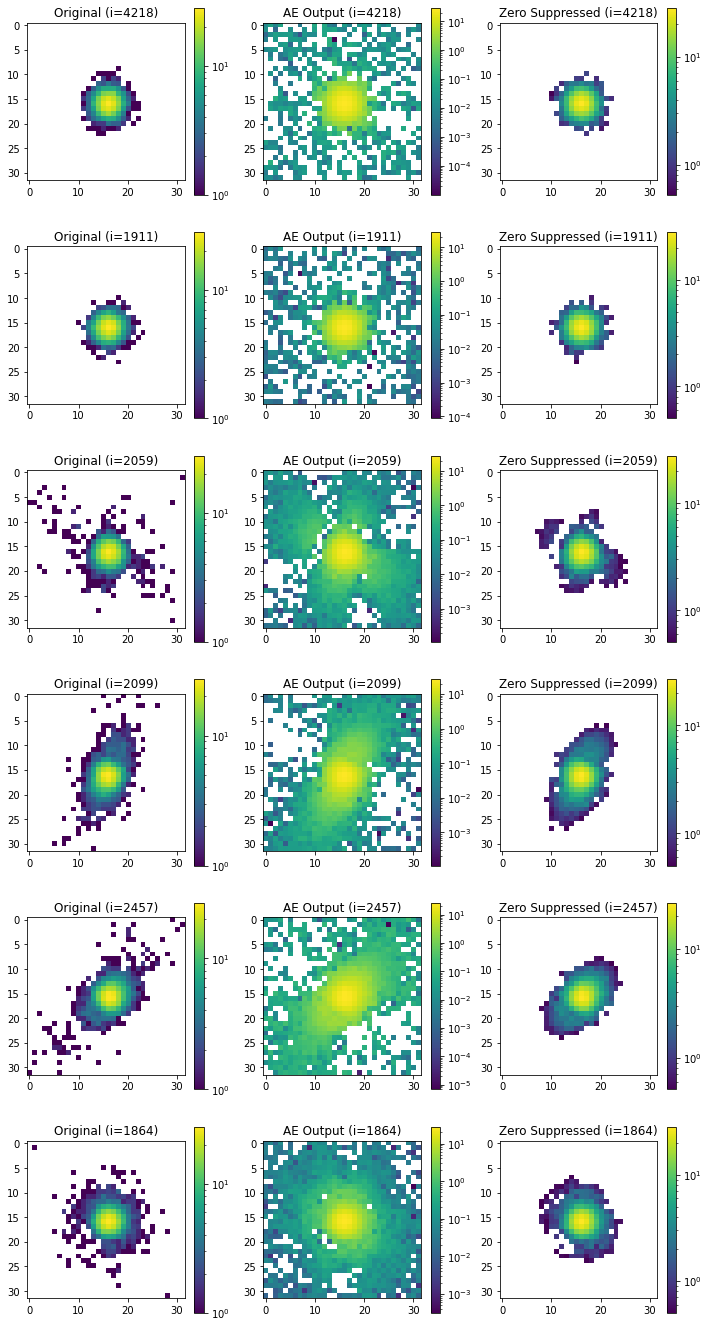

In [10]:
fig,ax = plt.subplots(len(N),3,figsize=(12,4*len(N)))

for i in range(len(N)):
    im = ax[i][0].imshow(dataCroppedFlat[N[i]].reshape(32,32),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][0])
    ax[i][0].set_title(f'Original (i={N[i]})')
    
    im = ax[i][1].imshow(output[N[i]].reshape(32,32),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][1])
    ax[i][1].set_title(f'AE Output (i={N[i]})')

    im = ax[i][2].imshow(outputZS[N[i]].reshape(32,32),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][2])
    ax[i][2].set_title(f'Zero Suppressed (i={N[i]})')
    
plt.savefig("32x32cropped_baseline.png")

In [11]:
output_reshaped = output.reshape(1, 4488, 32, 32)
outputZS_reshaped = outputZS.reshape(1, 4488, 32, 32)
# in reconstruct_ptycho_PCA_dataset.py, need to change n_ls = ['...'] to the according name(s) e.g. ['test4'] for data_cell_phase_test4.h5
with h5py.File('data_cell_phase_32x32cropped_baseline.h5','a') as f:
    f.create_dataset('exchange/data',data=output_reshaped,dtype=np.float32)
with h5py.File('data_cell_phase_32x32croppedZS_baseline.h5','a') as f:
    f.create_dataset('exchange/data',data=outputZS_reshaped,dtype=np.float32)

### Merge 32x32

In [12]:
inputs = Input(shape=(1024),name='input')
encoder = Dense(128, activation="linear")
decoder = Dense(1024, activation="linear")

x = encoder(inputs)
x = decoder(x)

autoencoder = Model(inputs, x)
autoencoder.summary()
autoencoder.compile(metrics=['accuracy'],optimizer="adam", loss="mse")

autoencoder.fit(dataMergeFlat, dataMergeFlat,
                epochs=100,
                validation_split=.1,
                verbose=0
               )

output = autoencoder.predict(dataMergeRefFlat)
outputZS = np.where(output>0.5,output,0)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1024)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              132096    
Total params: 263,296
Trainable params: 263,296
Non-trainable params: 0
_________________________________________________________________


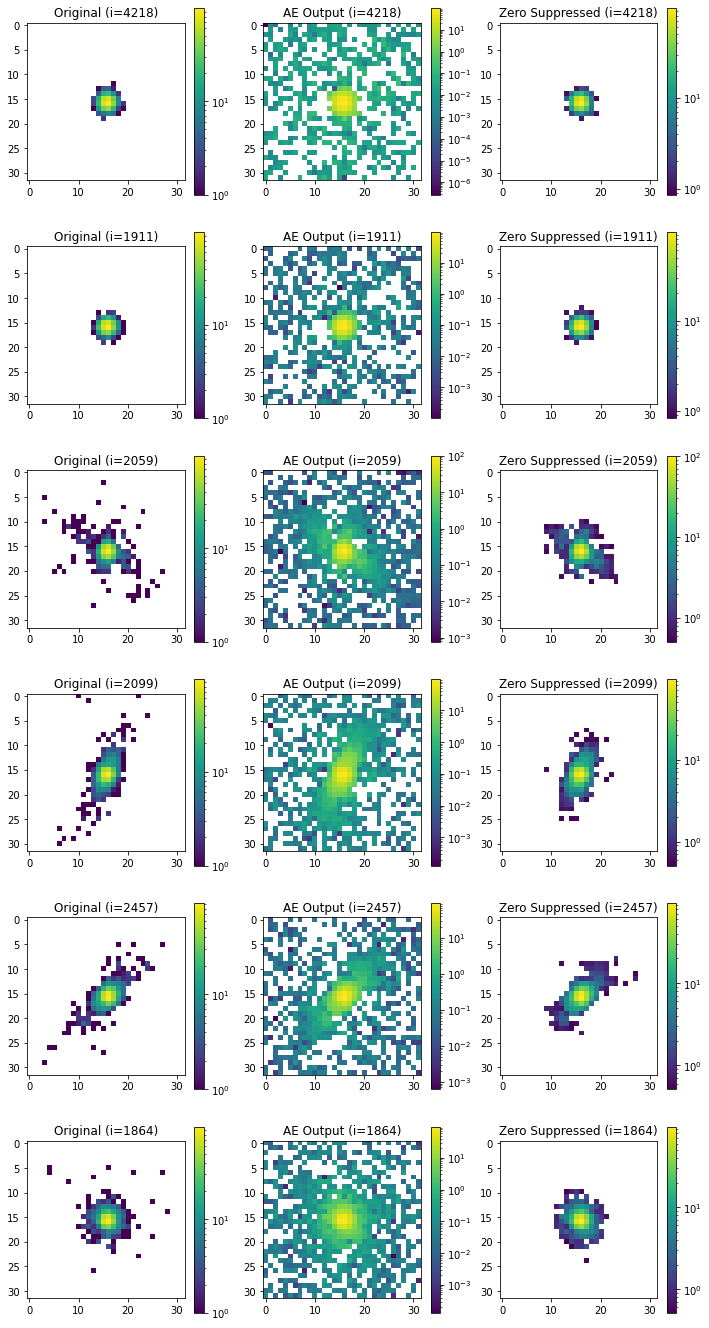

In [13]:
fig,ax = plt.subplots(len(N),3,figsize=(12,4*len(N)))

for i in range(len(N)):
    im = ax[i][0].imshow(dataMergeFlat[N[i]].reshape(32,32),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][0])
    ax[i][0].set_title(f'Original (i={N[i]})')
    
    im = ax[i][1].imshow(output[N[i]].reshape(32,32),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][1])
    ax[i][1].set_title(f'AE Output (i={N[i]})')

    im = ax[i][2].imshow(outputZS[N[i]].reshape(32,32),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][2])
    ax[i][2].set_title(f'Zero Suppressed (i={N[i]})')
    
plt.savefig("32x32merged_baseline.png")

In [14]:
output_reshaped = output.reshape(1, 4488, 32, 32)
outputZS_reshaped = outputZS.reshape(1, 4488, 32, 32)
# in reconstruct_ptycho_PCA_dataset.py, need to change n_ls = ['...'] to the according name(s) e.g. ['test4'] for data_cell_phase_test4.h5
with h5py.File('data_cell_phase_32x32merged_baseline.h5','a') as f:
    f.create_dataset('exchange/data',data=output_reshaped,dtype=np.float32)
with h5py.File('data_cell_phase_32x32mergedZS_baseline.h5','a') as f:
    f.create_dataset('exchange/data',data=outputZS_reshaped,dtype=np.float32)

# Deeper ReLU model
1024 -> 256 -> 128 -> 256 -> 1024, ReLU activation

### Cropped 32x32

In [15]:
inputs = Input(shape=(1024),name='input')
encoder1 = Dense(256, activation="relu")
bn1 = BatchNormalization()
encoder2 = Dense(128, activation="relu")
bn2 = BatchNormalization()
decoder1 = Dense(256, activation="relu")
bn3 = BatchNormalization()
decoder2 = Dense(1024, activation="relu")

x = encoder1(inputs)
x = bn1(x)
x = encoder2(x)
x = bn2(x)
x = decoder1(x)
x = bn3(x)
x = decoder2(x)

autoencoder = Model(inputs, x)
autoencoder.summary()
autoencoder.compile(metrics=['accuracy'],optimizer="adam", loss="mse")

autoencoder.fit(dataCroppedFlat, dataCroppedFlat,
                epochs=100,
                validation_split=.1,
                verbose=0
               )

output = autoencoder.predict(dataCroppedRefFlat)
outputZS = np.where(output>0.5,output,0)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1024)]            0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               262400    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024

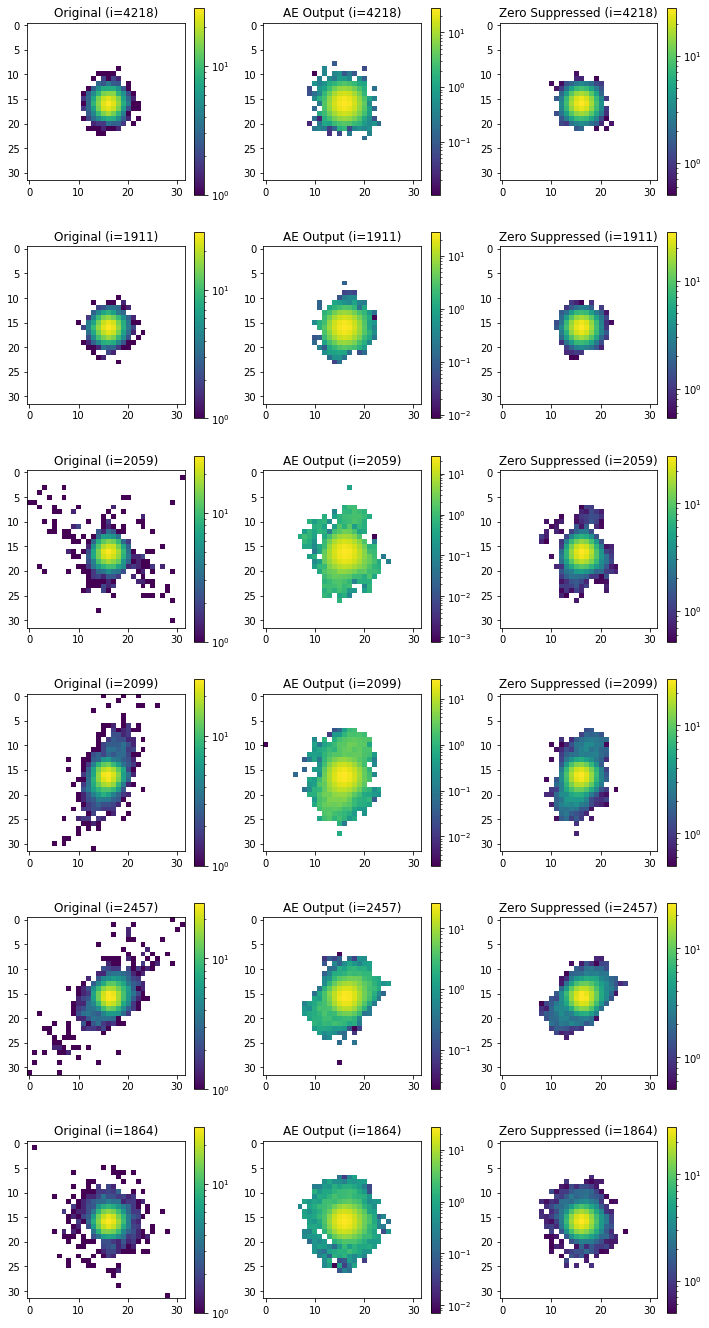

In [16]:
fig,ax = plt.subplots(len(N),3,figsize=(12,4*len(N)))

for i in range(len(N)):
    im = ax[i][0].imshow(dataCroppedFlat[N[i]].reshape(32,32),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][0])
    ax[i][0].set_title(f'Original (i={N[i]})')
    
    im = ax[i][1].imshow(output[N[i]].reshape(32,32),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][1])
    ax[i][1].set_title(f'AE Output (i={N[i]})')

    im = ax[i][2].imshow(outputZS[N[i]].reshape(32,32),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][2])
    ax[i][2].set_title(f'Zero Suppressed (i={N[i]})')
    
plt.savefig("32x32cropped_relu.png")

In [17]:
output_reshaped = output.reshape(1, 4488, 32, 32)
outputZS_reshaped = outputZS.reshape(1, 4488, 32, 32)
# in reconstruct_ptycho_PCA_dataset.py, need to change n_ls = ['...'] to the according name(s) e.g. ['test4'] for data_cell_phase_test4.h5
with h5py.File('data_cell_phase_32x32cropped_relu.h5','a') as f:
    f.create_dataset('exchange/data',data=output_reshaped,dtype=np.float32)
with h5py.File('data_cell_phase_32x32croppedZS_relu.h5','a') as f:
    f.create_dataset('exchange/data',data=outputZS_reshaped,dtype=np.float32)

### Merge 32x32

In [18]:
inputs = Input(shape=(1024),name='input')
encoder1 = Dense(256, activation="relu")
bn1 = BatchNormalization()
encoder2 = Dense(128, activation="relu")
bn2 = BatchNormalization()
decoder1 = Dense(256, activation="relu")
bn3 = BatchNormalization()
decoder2 = Dense(1024, activation="relu")

x = encoder1(inputs)
x = bn1(x)
x = encoder2(x)
x = bn2(x)
x = decoder1(x)
x = bn3(x)
x = decoder2(x)


autoencoder = Model(inputs, x)
autoencoder.summary()
autoencoder.compile(metrics=['accuracy'],optimizer="adam", loss="mse")

autoencoder.fit(dataMergeFlat, dataMergeFlat,
                epochs=100,
                validation_split=.1,
                verbose=0
               )

output = autoencoder.predict(dataMergeRefFlat)
outputZS = np.where(output>0.5,output,0)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1024)]            0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               262400    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024

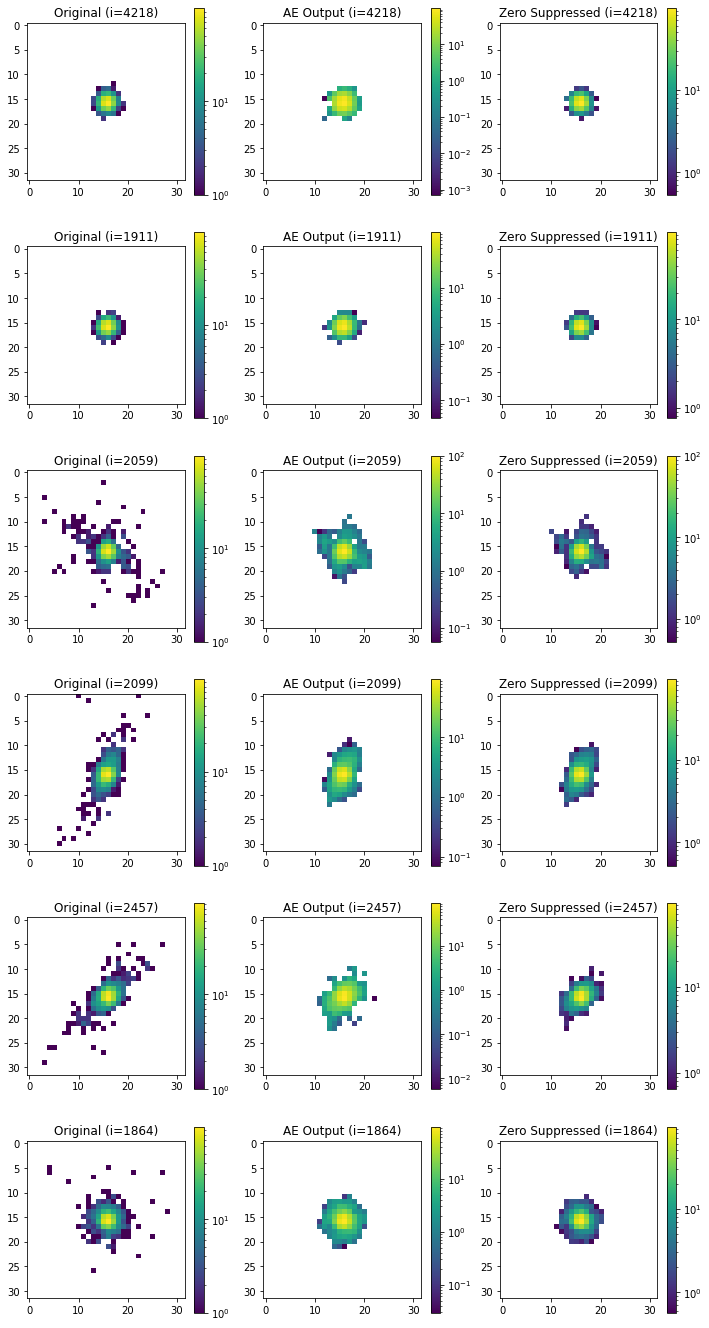

In [19]:
fig,ax = plt.subplots(len(N),3,figsize=(12,4*len(N)))

for i in range(len(N)):
    im = ax[i][0].imshow(dataMergeFlat[N[i]].reshape(32,32),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][0])
    ax[i][0].set_title(f'Original (i={N[i]})')
    
    im = ax[i][1].imshow(output[N[i]].reshape(32,32),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][1])
    ax[i][1].set_title(f'AE Output (i={N[i]})')

    im = ax[i][2].imshow(outputZS[N[i]].reshape(32,32),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][2])
    ax[i][2].set_title(f'Zero Suppressed (i={N[i]})')
    
plt.savefig("32x32merged_relu.png")

In [20]:
output_reshaped = output.reshape(1, 4488, 32, 32)
outputZS_reshaped = outputZS.reshape(1, 4488, 32, 32)
# in reconstruct_ptycho_PCA_dataset.py, need to change n_ls = ['...'] to the according name(s) e.g. ['test4'] for data_cell_phase_test4.h5
with h5py.File('data_cell_phase_32x32merged_relu.h5','a') as f:
    f.create_dataset('exchange/data',data=output_reshaped,dtype=np.float32)
with h5py.File('data_cell_phase_32x32mergedZS_relu.h5','a') as f:
    f.create_dataset('exchange/data',data=outputZS_reshaped,dtype=np.float32)

## NOTE: Need to delete all .h5 files before running to avoid existing dataset errors

Reconstruction notes: 

For 72x72 reconstruction,  
'probe_size': (72, 72),  
'probe_pos': [(y, x) for y in (np.arange(66) * 5) - 36 for x in (np.arange(68) * 5) - 36],  

For 32x32 reconstruction,  
'probe_size': (32, 32),  
'probe_pos': [(y, x) for y in (np.arange(66) * 5) - 16 for x in (np.arange(68) * 5) - 16],  